In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2
import h5py
import matplotlib.image as mpimg
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import json
# import xmltodict
import sys
from skimage import io
# import neccessary packages
import numpy as np
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

## Data Preparation ##

Mount to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import custom helper functions

In [3]:
!cp '/content/gdrive/Shareddrives/zxdrive/APS360 Project/yolov1/yolo_utilities.py' 'yolo_utilities.py'

In [9]:
import yolo_utilities as yolo

Unzip Datasets to local

In [ ]:
!unzip '/content/gdrive/Shared drives/zxdrive/APS360 Project/tr.zip'
!unzip '/content/gdrive/Shared drives/zxdrive/APS360 Project/train.zip'

Preparation of the training set

In [7]:
dataPath = "/content/train"
edataPath = "/content/tr/train"

In [17]:
img_list = yolo.get_imlist(dataPath)
len(img_list)

1478

In [11]:
img_list2 = yolo.get_imlist(edataPath)
len(img_list2)

6080

In [12]:
img_list = yolo.get_imlist(dataPath)

In [13]:
eimglist = yolo.get_imlist(edataPath)

In [15]:
img_list.extend(eimglist[2558:])

In [16]:
len(img_list)

5000

## Model Definition

Custom a yolonet using VGG16 as the backbone and attach three FC layers to the end that acts as a classifier.

In [34]:
yolonet = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [35]:
yolonet.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 2028),
    nn.Sigmoid(),
    yolo.Reshape(-1, 13,13,12),
)

In [ ]:
yolonet(torch.rand(1,3,416,416)).shape

torch.Size([1, 13, 13, 12])

## Training

Define training function

In [91]:
import time
def trainYOLO(net, train_data, lr = 0.001, epochs = 5, bs = 8,  lambdaCoord = 5, lambdaNoobj =0.5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs,
                        shuffle=True, num_workers=0)

    net = net.to(device)
    
    timeStamp = str(time.time()).split(".")[0]
    
    file = r'/content/gdrive/Shareddrives/zxdrive/APS360 Project/yolov1/train_1/trainingLog_{}.txt'.format(timeStamp)
    

    opt =torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    loss_func = yolo.YOLOLoss(lambdaCoord, lambdaNoobj)

    itera = 0

    net.train()

    loss_l = []
    closs_l = []
    learning_rate = lr

    for epoch in range(epochs):
        
            if epoch == 20:
                learning_rate=0.005
                
            if epoch == 40:
                learning_rate=0.001
                
            for param_group in opt.param_groups:
                param_group['lr'] = learning_rate
 
            for i, data in enumerate(train_loader, 0):

                torch.autograd.set_detect_anomaly(True)

                total_loss = 0

                inputs, labels = data["image"].float(), data["label"].float()

                # inputs = torch.autograd.Variable(inputs, requires_grad=False) 
                # labels = torch.autograd.Variable(labels, requires_grad=False) 

                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = net(inputs)

                total_loss, classLoss = loss_func(outputs, labels)

                opt.zero_grad()

                total_loss.backward()

                opt.step()

                itera += 1
                loss_l.append(total_loss.item())

                closs_l.append(classLoss.item())

                print("\r"+ "Epoch: " + str(epoch) + " Iterations: " + str(itera) + " TotalLoss: " + "{:0.3f}".format( total_loss.item() ) + " classLoss: " + "{:0.3f}".format( classLoss.item()  ) , end = "",flush=True)
                
                with open(file, 'a+') as f:
                     f.write("Epoch: " + str(epoch) + " Iterations: " + str(itera) + " TotalLoss: " + "{:0.3f}".format( total_loss.item() ) + " classLoss: " + "{:0.3f}".format( classLoss.item()  ) +'\n')   #加\n换行显示
            
            if epoch % 4 == 0:
                torch.save(net, '/content/gdrive/Shareddrives/zxdrive/APS360 Project/yolov1/train_1/{}_yolo_epoch{}.pkl'.format(timeStamp, epoch) )

    torch.cuda.empty_cache()
    return loss_l, closs_l

Define the loss function

In [ ]:
class yoloLoss(nn.Module):
    def __init__(self,S,B,l_coord,l_noobj):
        super(yoloLoss,self).__init__()
        self.S = S
        self.B = B
        self.l_coord = l_coord
        self.l_noobj = l_noobj

    def compute_iou(self, box1, box2):
        '''Compute the intersection over union of two set of boxes, each box is [x1,y1,x2,y2].
        Args:
          box1: (tensor) bounding boxes, sized [N,4].
          box2: (tensor) bounding boxes, sized [M,4].
        Return:
          (tensor) iou, sized [N,M].
        '''
        N = box1.size(0)
        M = box2.size(0)

        lt = torch.max(
            box1[:,:2].unsqueeze(1).expand(N,M,2),  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:,:2].unsqueeze(0).expand(N,M,2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )

        rb = torch.min(
            box1[:,2:].unsqueeze(1).expand(N,M,2),  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:,2:].unsqueeze(0).expand(N,M,2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )

        wh = rb - lt  # [N,M,2]
        wh[wh<0] = 0  # clip at 0
        inter = wh[:,:,0] * wh[:,:,1]  # [N,M]

        area1 = (box1[:,2]-box1[:,0]) * (box1[:,3]-box1[:,1])  # [N,]
        area2 = (box2[:,2]-box2[:,0]) * (box2[:,3]-box2[:,1])  # [M,]
        area1 = area1.unsqueeze(1).expand_as(inter)  # [N,] -> [N,1] -> [N,M]
        area2 = area2.unsqueeze(0).expand_as(inter)  # [M,] -> [1,M] -> [N,M]

        iou = inter / (area1 + area2 - inter)
        return iou
    def forward(self,pred_tensor,target_tensor):
        '''
        pred_tensor: (tensor) size(batchsize,S,S,Bx5+20=30) [x,y,w,h,c]
        target_tensor: (tensor) size(batchsize,S,S,30)
        '''
        N = pred_tensor.size()[0]
        coo_mask = target_tensor[:,:,:,4] > 0
        noo_mask = target_tensor[:,:,:,4] == 0
        coo_mask = coo_mask.unsqueeze(-1).expand_as(target_tensor)
        noo_mask = noo_mask.unsqueeze(-1).expand_as(target_tensor)

        coo_pred = pred_tensor[coo_mask].view(-1,30)
        box_pred = coo_pred[:,:10].contiguous().view(-1,5) #box[x1,y1,w1,h1,c1]
        class_pred = coo_pred[:,10:]                       #[x2,y2,w2,h2,c2]
        
        coo_target = target_tensor[coo_mask].view(-1,30)
        box_target = coo_target[:,:10].contiguous().view(-1,5)
        class_target = coo_target[:,10:]

        # compute not contain obj loss
        noo_pred = pred_tensor[noo_mask].view(-1,30)
        noo_target = target_tensor[noo_mask].view(-1,30)
        noo_pred_mask = torch.cuda.ByteTensor(noo_pred.size())
        noo_pred_mask.zero_()
        noo_pred_mask[:,4]=1;noo_pred_mask[:,9]=1
        noo_pred_c = noo_pred[noo_pred_mask] #noo pred只需要计算 c 的损失 size[-1,2]
        noo_target_c = noo_target[noo_pred_mask]
        nooobj_loss = F.mse_loss(noo_pred_c,noo_target_c,size_average=False)

        #compute contain obj loss
        coo_response_mask = torch.cuda.ByteTensor(box_target.size())
        coo_response_mask.zero_()
        coo_not_response_mask = torch.cuda.ByteTensor(box_target.size())
        coo_not_response_mask.zero_()
        box_target_iou = torch.zeros(box_target.size()).cuda()
        for i in range(0,box_target.size()[0],2): #choose the best iou box
            box1 = box_pred[i:i+2]
            box1_xyxy = Variable(torch.FloatTensor(box1.size()))
            box1_xyxy[:,:2] = box1[:,:2]/14. -0.5*box1[:,2:4]
            box1_xyxy[:,2:4] = box1[:,:2]/14. +0.5*box1[:,2:4]
            box2 = box_target[i].view(-1,5)
            box2_xyxy = Variable(torch.FloatTensor(box2.size()))
            box2_xyxy[:,:2] = box2[:,:2]/14. -0.5*box2[:,2:4]
            box2_xyxy[:,2:4] = box2[:,:2]/14. +0.5*box2[:,2:4]
            iou = self.compute_iou(box1_xyxy[:,:4],box2_xyxy[:,:4]) #[2,1]
            max_iou,max_index = iou.max(0)
            max_index = max_index.data.cuda()
            
            coo_response_mask[i+max_index]=1
            coo_not_response_mask[i+1-max_index]=1

            #####
            # we want the confidence score to equal the
            # intersection over union (IOU) between the predicted box
            # and the ground truth
            #####
            box_target_iou[i+max_index,torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
        box_target_iou = Variable(box_target_iou).cuda()
        #1.response loss
        box_pred_response = box_pred[coo_response_mask].view(-1,5)
        box_target_response_iou = box_target_iou[coo_response_mask].view(-1,5)
        box_target_response = box_target[coo_response_mask].view(-1,5)
        contain_loss = F.mse_loss(box_pred_response[:,4],box_target_response_iou[:,4],size_average=False)
        loc_loss = F.mse_loss(box_pred_response[:,:2],box_target_response[:,:2],size_average=False) + F.mse_loss(torch.sqrt(box_pred_response[:,2:4]),torch.sqrt(box_target_response[:,2:4]),size_average=False)
        #2.not response loss
        box_pred_not_response = box_pred[coo_not_response_mask].view(-1,5)
        box_target_not_response = box_target[coo_not_response_mask].view(-1,5)
        box_target_not_response[:,4]= 0
        #not_contain_loss = F.mse_loss(box_pred_response[:,4],box_target_response[:,4],size_average=False)
        
        #I believe this bug is simply a typo
        not_contain_loss = F.mse_loss(box_pred_not_response[:,4], box_target_not_response[:,4],size_average=False)

        #3.class loss
        class_loss = F.mse_loss(class_pred,class_target,size_average=False)

        return (self.l_coord*loc_loss + 2*contain_loss + not_contain_loss + self.l_noobj*nooobj_loss + class_loss)/N

Load pre-trained weights from Google Drive

In [ ]:
!cp '/content/gdrive/Shared drives/zxdrive/APS360 Project//yolov1/train_1/1607321830_yolo_epoch4.pkl' 'weight.pkl'

In [ ]:
yolonet = torch.load("/content/weight.pkl")

Training & Hyperparameters Tuning

In [ ]:
losses = trainYOLO(yolonet, train_dt, lr = 0.02, epochs = 60, bs = 24,  lambdaCoord = 5, lambdaNoobj =0.5)

Epoch: 59 Iterations: 18900 TotalLoss: 0.557 classLoss: 0.005

Store the new weight on Google Drive

In [ ]:
torch.save(yolonet, '/content/gdrive/Shared drives/zxdrive/APS360 Project/yolo_train0.02.pkl')

Plot the training results

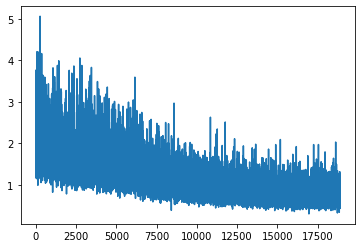

In [ ]:
plt.plot(losses[0])

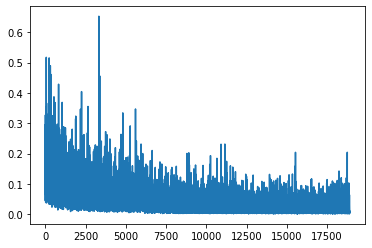

In [ ]:
plt.plot(losses[1])

## Testing

Obtain the test set from GDrive

In [ ]:
!unzip '/content/gdrive/Shared drives/zxdrive/APS360 Project/kaggle/face-mask-dataset-yolo-format.zip'

Set test path

In [80]:
test_path_1 = "/content/dataset/images/test"
test_list1 = yolo.get_imlist(test_path_1)

Set test data loader

In [81]:
test_dt = yolo.FaceDataset(test_list1,  transforms.Compose( [transforms.ColorJitter(brightness=0.4, contrast=0.4, hue=0.15), transforms.GaussianBlur([3,5]) ] ) , img_size = 416, transformProb = 2)

Print example test image

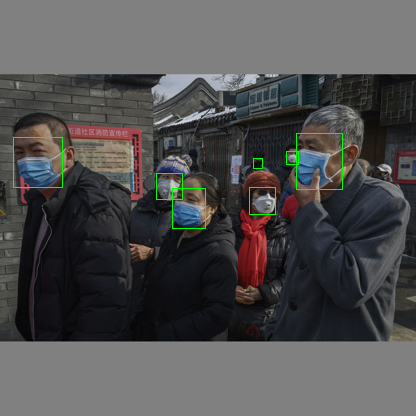

In [119]:
test_dataloader = torch.utils.data.DataLoader(test_dt, batch_size=1,
                        shuffle=True, num_workers=0)
sample = next(iter(test_dataloader))
sample["image"].shape, sample["label"].shape
yolo.drawPred ( transforms.ToPILImage()(sample["image"][0].squeeze()), sample["label"][0])

Load the best version of the weight obtained

In [126]:
!cp '/content/gdrive/Shareddrives/zxdrive/APS360 Project/yolov1/train_1/1607379214_yolo_epoch16.pkl' 'weight.pkl'
yolonet = torch.load("/content/weight.pkl")

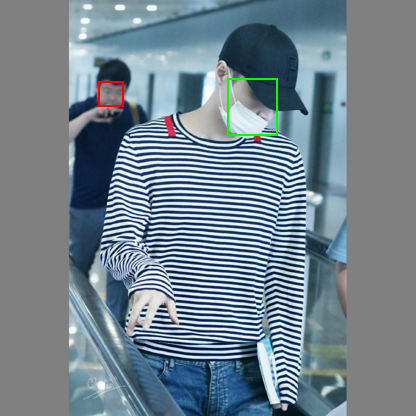

In [155]:
import random
img_idx = random.randint(0, len(test_list1))
img = Image.open(test_list1[img_idx])
img = yolo.squarePadImg(img, (416, 416))
yolonetcpu = yolonet.cpu().eval()
pred = yolonetcpu(transforms.ToTensor()(img).unsqueeze(dim = 0))
drawFinalResult(img.copy(), pred, thre = 0.2)

Get Testing Accuracy

In [46]:
test_acc = get_accuracy(test_dataloader)

num of images: 0: 1.0
num of images: 1: 0.8
num of images: 2: 0.9090909090909091
num of images: 3: 0.7142857142857143
num of images: 4: 0.7333333333333333
num of images: 5: 0.6521739130434783
num of images: 6: 0.5
num of images: 7: 0.5588235294117647
num of images: 8: 0.6052631578947368
num of images: 9: 0.6521739130434783
num of images: 10: 0.6538461538461539
num of images: 11: 0.6666666666666666
num of images: 12: 0.6551724137931034
num of images: 13: 0.647887323943662
num of images: 14: 0.6875
num of images: 15: 0.6746987951807228
num of images: 16: 0.6666666666666666
num of images: 17: 0.6705882352941176
num of images: 18: 0.6744186046511628
num of images: 19: 0.6774193548387096
num of images: 20: 0.6736842105263158
num of images: 21: 0.6770833333333334
num of images: 22: 0.69
num of images: 23: 0.7019230769230769
num of images: 24: 0.7129629629629629
num of images: 25: 0.7027027027027027
num of images: 26: 0.7053571428571429
num of images: 27: 0.7017543859649122
num of images: 28:

In [47]:
print(test_acc)

0.7059773828756059


Get Training Accuracy

In [48]:
train_dt = yolo.FaceDataset(img_list,  transforms.Compose( [transforms.ColorJitter(brightness=0.4, contrast=0.4, hue=0.15), transforms.GaussianBlur([3,5]) ] ) , img_size = 416, transformProb = 2)

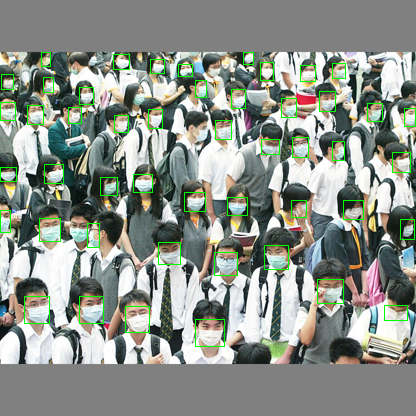

In [50]:
train_dataloader = torch.utils.data.DataLoader(train_dt, batch_size=1,
                        shuffle=False, num_workers=0)
sample = next(iter(train_dataloader))
sample["image"].shape, sample["label"].shape
yolo.drawPred ( transforms.ToPILImage()(sample["image"][0].squeeze()), sample["label"][0])

In [51]:
train_acc = get_accuracy(train_dataloader)

num of images: 0: 0.0
num of images: 1: 0.1111111111111111
num of images: 2: 0.10526315789473684
num of images: 3: 0.15
num of images: 4: 0.273972602739726
num of images: 5: 0.35365853658536583
num of images: 6: 0.3764705882352941
num of images: 7: 0.4065934065934066
num of images: 8: 0.4148936170212766
num of images: 9: 0.4387755102040816
num of images: 10: 0.45544554455445546
num of images: 11: 0.46601941747572817
num of images: 12: 0.4766355140186916
num of images: 13: 0.504424778761062
num of images: 14: 0.5042016806722689
num of images: 15: 0.5203252032520326
num of images: 16: 0.5338345864661654
num of images: 17: 0.5441176470588235
num of images: 18: 0.55
num of images: 19: 0.5531914893617021
num of images: 20: 0.5761589403973509
num of images: 21: 0.5816993464052288
num of images: 22: 0.5844155844155844
num of images: 23: 0.5949367088607594
num of images: 24: 0.6073619631901841
num of images: 25: 0.6190476190476191
num of images: 26: 0.6235294117647059
num of images: 27: 0.6179

In [53]:
print(train_acc)

0.8170958322272365


## Baseline Model


Define the baseline model

In [106]:
class Baseline(nn.Module):
      def __init__(self):
          super(Baseline, self).__init__()
          self.conv1 = nn.Conv2d(3, 3, 3) #in_channels, out_chanels, kernel_size 414*414*3
          self.conv2 = nn.Conv2d(3, 3, 4) #in_channels, out_chanels, kernel_size 207*207*3 => 204*204*3
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.fc1 = nn.Linear(102*102*3, 4056)
          self.fc2 = nn.Linear(4056, 4056)
          self.fc3 = nn.Linear(4056, 13*13*12)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x))) #102*102*10
          x = x.view(-1, 102*102*3)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = torch.sigmoid(self.fc3(x))
          #yolo.Reshape(-1, 13,13,12),
          #x = yolo.Reshape(x)
          return x.view(-1, 13,13,12)

In [97]:
class Baseline_Archived(nn.Module):
      def __init__(self):
          super(Baseline_Archived, self).__init__()
          self.conv1 = nn.Conv2d(3, 5, 3) #in_channels, out_chanels, kernel_size 414*414*3
          self.conv2 = nn.Conv2d(5, 5, 4) #in_channels, out_chanels, kernel_size 207*207*3 => 204*204*3
          self.conv3 = nn.Conv2d(5, 3, 3) #in_channels, out_chanels, kernel_size 207*207*3 => 204*204*3
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.fc1 = nn.Linear(50*50*3, 4056)
          self.fc2 = nn.Linear(4056, 4056)
          self.fc3 = nn.Linear(4056, 13*13*12)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x))) #102*102*10
          x = self.pool(F.relu(self.conv3(x)))
          x = x.view(-1, 50*50*3)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = torch.sigmoid(self.fc3(x))
          #yolo.Reshape(-1, 13,13,12),
          #x = yolo.Reshape(x)
          return x.view(-1, 13,13,12)

In [107]:
baseline_model = Baseline()

In [108]:
baseline_model(torch.rand(4,3,416,416)).shape

torch.Size([4, 13, 13, 12])

In [111]:
losses = trainYOLO(baseline_model, train_dt, lr = 0.0001, epochs = 20, bs = 24,  lambdaCoord = 5, lambdaNoobj =0.5)

Epoch: 19 Iterations: 1240 TotalLoss: 19.524 classLoss: 2.214

In [100]:
torch.save(baseline_model, '/content/gdrive/Shareddrives/zxdrive/APS360 Project/yolov1/baseline/1607394716_yolo_epoch16.pkl')

Baseline Loss Functions

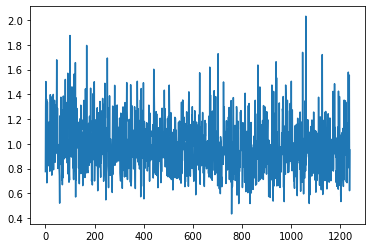

In [ ]:
plt.plot(losses[0])

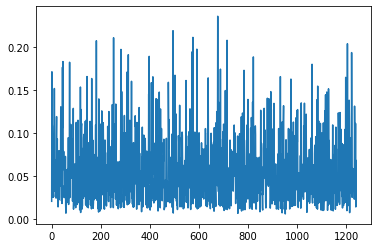

In [ ]:
plt.plot(losses[1])

Test Baseline Model

In [109]:
!cp '/content/gdrive/Shareddrives/zxdrive/APS360 Project/yolov1/train_1/1607560207_yolo_epoch16.pkl' 'baseline.pkl'
baseline_model = torch.load("/content/baseline.pkl")

In [ ]:
bs_acc = get_accuracy(baseline_model, train_dataloader)

In [ ]:
print(bs_acc)

## Some error checking and Debugging codes

In [ ]:
img = Image.open(r"/home/featurize/myyolo/US-expands-coronavirus-screenings-United-suspends-some-flights-to-China.jpg")

In [ ]:
transforms.ColorJitter(brightness=0.4, contrast=0.4, hue=0.15)(img)

In [ ]:
train_dt = yolo.FaceDataset(img_list,  transforms.Compose( [transforms.ColorJitter(brightness=0.4, contrast=0.4, hue=0.15), transforms.GaussianBlur([3,5]) ] ) , img_size = 416, transformProb = 2)

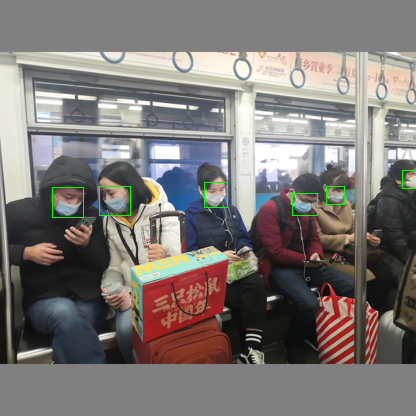

In [44]:
train_dataloader = torch.utils.data.DataLoader(train_dt, batch_size=8,
                        shuffle=False, num_workers=0)
sample = next(iter(train_dataloader))
sample["image"].shape, sample["label"].shape
yolo.drawPred ( transforms.ToPILImage()(sample["image"][1].squeeze()), sample["label"][1])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Mon Dec  7 07:18:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    40W / 300W |   1725MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# img = Image.open(os.path.join(dataPath, r"0_10725.jpg"))
img = Image.open(r"/home/featurize/myyolo/1d213741c4eda7906bd5140b17d21ce.png")
isize = img.size
img = yolo.squarePadImg(img, (416,416))
yolonetcpu = yolonet.cpu().eval()
pred = yolonetcpu( transforms.ToTensor()(img).unsqueeze(dim = 0) )

In [ ]:
torch.max(pred[...,2:4])

tensor(0.5229, grad_fn=<MaxBackward1>)

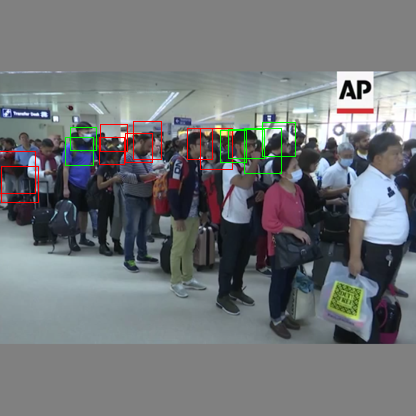

In [ ]:
yolo.drawPred(img.copy() , pred, thre = 0.3)

In [ ]:
! pwd

/home/featurize/myyolo


In [ ]:
pred_tensor = x.cuda()
target_tensor = x.cuda()

In [ ]:
    mseloss = nn.MSELoss(reduction="sum")
    BS = pred_tensor.shape[0]
    biou1 = yolo.bbox_iou(pred_tensor[...,4:8], target_tensor[...,4:8],  yolo=True)
    biou2 = yolo.bbox_iou(pred_tensor[...,8:12], target_tensor[...,8:12] , yolo=True)
    
    with torch.no_grad():
        target_tensor[...,2] = (biou1 > biou2) * target_tensor[...,2].clone()
        target_tensor[...,3] = (biou1 <= biou2) * target_tensor[...,3].clone()

    target_tensor[...,2] = (biou1) * target_tensor[...,2].clone()
    target_tensor[...,3] = (biou2) * target_tensor[...,3].clone()

    box1mask = target_tensor[...,2] > 0
    box2mask = target_tensor[...,3] > 0

    gridmask = torch.logical_or(target_tensor[..., 2] > 0, target_tensor[..., 3] > 0)

    box1centerloss = mseloss(pred_tensor[...,4:6][box1mask], target_tensor[...,4:6][box1mask])
    box1whloss = mseloss( torch.sqrt(pred_tensor[...,6:8][box1mask] + 1e-6), torch.sqrt(target_tensor[...,6:8][box1mask] + 1e-6) )
    box1closs = mseloss(pred_tensor[...,2][box1mask], target_tensor[...,2][box1mask])
    noobjbox1closs = mseloss(pred_tensor[...,2][~box1mask], target_tensor[...,2][~box1mask])

    box1loss = 5 * ( box1centerloss + box1whloss) + box1closs + 0.5 * noobjbox1closs


    box2centerloss = mseloss(pred_tensor[...,8:10][box2mask], target_tensor[...,8:10][box2mask])
    box2whloss = mseloss( torch.sqrt(pred_tensor[...,10:12][box2mask] + 1e-6), torch.sqrt(target_tensor[...,10:12][box2mask] + 1e-6) )
    box2closs = mseloss(pred_tensor[...,3][box2mask], target_tensor[...,3][box2mask])
    noobjbox2closs = mseloss(pred_tensor[...,3][~box2mask], target_tensor[...,3][~box2mask])

    box2loss = 5 * ( box2centerloss + box2whloss) + box2closs + 0.5 * noobjbox2closs

    classloss = mseloss(pred_tensor[...,0:2][gridmask], target_tensor[...,0:2][gridmask])


    loss = (box1loss + box2loss + classloss) / BS

In [ ]:
 biou2.max()

tensor(1., device='cuda:0')

In [ ]:
noobjbox2closs

tensor(0., device='cuda:0')

In [ ]:
noobjbox1closs

tensor(5., device='cuda:0')

In [ ]:
box1loss

tensor(2.5000, device='cuda:0')

In [ ]:
loss

tensor(0.1923, device='cuda:0')

In [ ]:
x = torch.rand(4,7,7,30).cuda()

In [ ]:
Loss(7,2,20,5,0.5)(x, x)

/environment/python/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/environment/python/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/environment/python/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:135: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/environment/python/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.

tensor(17.3463, device='cuda:0')

In [ ]:
yoloLoss(7,2,5,0.5)(x, x)

/environment/python/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/environment/python/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/environment/python/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/environment/python/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.

tensor(50.7212, device='cuda:0')

## Some Helper Functions

In [26]:
def filterLowProbBoxes(boxes,thre = 0.2):
    keep = []
    for i in range(len(boxes)):
        if boxes[i][4] < 0.2:
            continue
        keep.append(i)
    return keep


def getBoxes(pred, gridN = 13):
    pred = pred.squeeze()
    boxes = np.ones((13*13, 7))
    c = 0
    gridS = 1
    for i in range(13):
        for j in range(13):
            if pred[i][j][2].detach().numpy() > pred[i][j][3].detach().numpy():
                boxes[c,0:4] = pred[i][j][4:8].detach().numpy()
                boxes[c,4] = pred[i][j][2].detach().numpy()
            else:
                boxes[c , 0:4] = pred[i][j][8:12].detach().numpy()
                boxes[c ,4] = pred[i][j][3].detach().numpy()

            xc, yc, w, h = boxes[c, 0], boxes[c, 1], boxes[c, 2], boxes[c, 3]

            xc = (i * gridS + xc * gridS) / gridN
            yc = (j * gridS + yc * gridS) / gridN


            x1, y1, x2, y2 = xc - w/2, yc - h/2, xc + w/2, yc + h/2
            boxes[c,0:4] = np.array([x1, y1, x2, y2])
            boxes[c, 5:7] = pred[i][j][0:2].detach().numpy()
            c += 1
    return boxes

def calculateAccForSingleImg (labels, predictions, thre = 0.2, iou_thre = 0.4):
    labels = getBoxes(labels)
    predictions = getBoxes(predictions)
    labels = labels[filterLowProbBoxes(labels,thre = thre)]
    predictions = predictions[filterLowProbBoxes(predictions,thre = thre)]
    index = torchvision.ops.nms( torch.from_numpy(predictions[:,0:4]).float(), torch.from_numpy(predictions[:,4]).float(), 0.01 ).numpy()
    predictions = predictions[index]
    tacc = 0
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    taken = []

    iou_matrix = torchvision.ops.box_iou(torch.from_numpy(predictions[:,0:4]).float(), torch.from_numpy(labels[:,0:4]).float())

    for j in range(len(labels)):
        if labels[j,5:7].argmax() == 0:
            tp += 1
        else:
            tn += 1

    for i in range(len(predictions)):
        max_iou = -1
        mindex = 0
        for j in range(len(labels)):
            if j in taken:
                continue
            iou =  iou_matrix[i][j].item()
            if iou > max_iou:
                max_iou = iou
                mindex = j

        if max_iou > iou_thre:
            taken.append(mindex)
            if predictions[i,5:7].argmax() == labels[mindex,5:7].argmax():
                tacc += 1
            elif predictions[i,5:7].argmax() == 0:
                fp += 1
            elif predictions[i,5:7].argmax() == 1:
                fn += 1

    detecAcc = len(taken) / len(labels)
    taccr = tacc / len(labels)

    return {
        "detectionAcc" : detecAcc,
        "generalAcc" : taccr,
        "fpRate" : 0 if len(taken) == 0 else (fp/len(taken)),
        "fnRate" : 0 if len(taken) == 0 else (fn/len(taken)),
        "totalFacesInLabels" : len(labels),
        "totalFacesSuccessfullyPred" : len(taken),
        "totalFacesSuccessfullyPredandClassified" : tacc,
        "fpNum" : fp,
        "fnNum" : fn,
        "tpNum" :tp,
        "tnNum" : tn,
        "wrongDetectionNum" : len(predictions) - len(taken),

    }



Functions to obtain accuracy

In [60]:
def get_accuracy(net, data_loader):
    label_len = 0
    successfully_predicted = 0
    final_fp = 0
    final_fn = 0
    success_pred = 0

    acc_list = []
    net.cuda()

    for i, data in enumerate(data_loader, 0):

        inputs, labels = data["image"].float(), data["label"].float()

        inputs = inputs.cuda()
        labels = labels.cuda()

        output = net(inputs).detach()
        # yolonetcpu = yolonet.cpu().eval()
        # output = yolonetcpu(inputs).cpu()

        for j in range(labels.shape[0]):
            acc = calculateAccForSingleImg(labels[j].cpu(), output[j].cpu(), 0.2, 0.4)
            acc_list.append(acc)

            label_len += acc['totalFacesInLabels']
            successfully_predicted += acc['totalFacesSuccessfullyPred']
            final_fn += acc['fnNum']
            final_fp += acc['fpNum']
            success_pred += acc['totalFacesSuccessfullyPred']
            print('num of images: {}: {}'.format(i, successfully_predicted/label_len))

    return successfully_predicted/label_len

In [124]:
def drawFinalResult (img, pred, thre = 0.5, nms_thre = 0.01):
    imgcp = img
    size = img.size
    draw = ImageDraw.Draw(imgcp)
    boxes = getBoxes(pred)
    index = torchvision.ops.nms( torch.from_numpy(boxes[:,0:4]).float(), torch.from_numpy(boxes[:,4]).float(), nms_thre ).numpy()
    boxes = boxes[index]

    for i in range(boxes.shape[0]):

        if boxes[i][4] > thre:

            outline = (255, 0, 0) if boxes[i][6] > boxes[i][5] else (0, 255, 0)
            #outline = (255, 255, 255)

            draw.rectangle( [boxes[i][0] * size[0], boxes[i][1] * size[1], boxes[i][2] * size[0], boxes[i][3] * size[1]], outline = outline, width = 2)

    return imgcp